# Proton NMR - Technical

## Imports and Definitions

In [1]:
# python modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob
from scipy.optimize import curve_fit, minimize
from scipy.constants import physical_constants
from allantools import oadev

# external function definitions
from nmrLib import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

## Pump Flow Rate

In [3]:
# load the data from the file
data = np.loadtxt('data/20211128_pumpFlowRate.txt')

# control voltage for the pump power in [V]
controlVoltage = data[:,0]

# time that the water was collected in [s]
pumpTime = np.array([30,0.5])

# tube radius in [m]
tubeRadius = 0.002

In [4]:
# weight of the collected water in [g]
pumpVolume = data[:,1:]
pumpVolume = np.array([pumpVolume.mean(axis=1), pumpVolume.std(axis=1)])

# flow velocity through interaction region in [m/s]
flowVelocity = 1e-6*np.array([pumpVolume[0]/pumpTime[0]/(tubeRadius**2*np.pi), 
                              np.sqrt(pumpVolume[1]**2/pumpTime[0]**2/tubeRadius**4/np.pi**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4/tubeRadius**4/np.pi**2)])

# flow rate of pump in [l/min]
flowRate = 60/1000*np.array([pumpVolume[0]/pumpTime[0], 
                             np.sqrt(pumpVolume[1]**2/pumpTime[0]**2 + pumpVolume[0]**2*pumpTime[1]**2/pumpTime[0]**4)])

2.0 V: 1.27 m/s
2.5 V: 1.63 m/s
3.0 V: 2.03 m/s
3.5 V: 2.35 m/s
4.0 V: 2.65 m/s

0.53 +/- 0.02 l/min/V
0.71 +/- 0.02 m/s/V


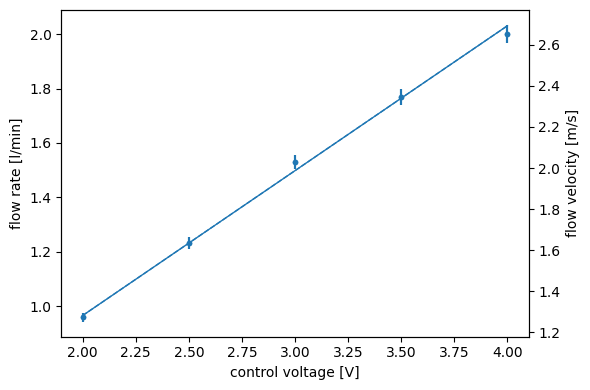

In [5]:
# print measured values
for i,(u,v) in enumerate(zip(controlVoltage, flowVelocity[0])):
    print('{} V: {:.02f} m/s'.format(u,v))

# create the figure
fig, ax = plt.subplots()

# fit the flow rate and print the value
popt, pcov = curve_fit(linFct, controlVoltage, flowRate[0], sigma=flowRate[1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print('\n{:.02f} +/- {:.02f} l/min/V'.format(popt[0], perr[0]))

# plot the flow rate with the fit
ax.errorbar(controlVoltage, flowRate[0], flowRate[1], fmt='C0.')
ax.plot(controlVoltage, linFct(controlVoltage, *popt), 'C0--', lw=1)
ax.set(xlabel='control voltage [V]', ylabel='flow rate [l/min]')

# fit the flow velocity and print the value
popt, pcov = curve_fit(linFct, controlVoltage, flowVelocity[0], sigma=flowVelocity[1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print('{:.02f} +/- {:.02f} m/s/V'.format(popt[0], perr[0]))

# create the second axis
ax2 = ax.twinx()
ax2.errorbar(controlVoltage, flowVelocity[0], flowVelocity[1], fmt='C0.')
ax2.plot(controlVoltage, linFct(controlVoltage, *popt), 'C0-', lw=1)
ax2.set(ylabel='flow velocity [m/s]')

fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure3.eps')
plt.show()

## Polarizer

In [6]:
# magnetic field of the polarizer in [T]
B_p = 190e-3

# temperature in [K]
T = 293.15

# polarization
P_0 = np.tanh(physical_constants['proton gyromag. ratio'][0] 
              * physical_constants['Planck constant over 2 pi'][0] 
              * B_p 
              / 2
              / physical_constants['Boltzmann constant'][0] 
              / T)

print('polarization: {:.2f} ppm'.format(P_0*1e6))

polarization: 0.66 ppm


## NMR Signal

sampling interval:	7.8125 us
exponential decay time:	(155 +/- 7) us


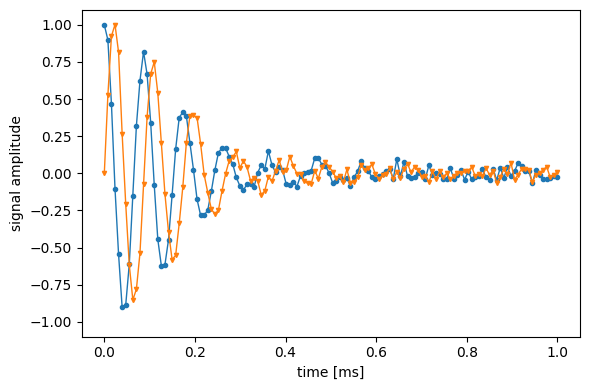

In [7]:
file = 'data/20220303_nmrSignal.txt'

# spectral width in [Hz]
specWidth = 128e3

# sampling interval in [s]
tdwell = 1/specWidth
print('sampling interval:\t{} us'.format(1e6*tdwell))

# load the signal from the data file
sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

# create the time array
time = np.linspace(0, len(sig)*tdwell, len(sig))

# normalize the signal
sig = sig/sig.max()

# fit the signal to get the exponential decay time
popt = (12e3, 1, 90, 2e-4)
popt, pcov = curve_fit(nmrSignal, time, sig.real, p0=popt)
perr = np.sqrt(np.diag(pcov))
print('exponential decay time:\t({:.0f} +/- {:.0f}) us'.format(popt[3]*1e6, perr[3]*1e6))

# plot the NMR signal
fig, ax = plt.subplots()
ax.plot(time*1e3, sig.real, 'C0o-', ms=3, lw=1)
ax.plot(time*1e3, sig.imag, 'C1v-', ms=3, lw=1)
ax.set(xlabel='time [ms]', ylabel='signal amplitude', ylim=(-1.1, 1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure10.eps')
plt.show()

## NMR Spectrum

X² / NDF:	1058 / 251 = 4.2
T2*:		(148 +/- 2) us
Sw:		24.3 +/- 0.5


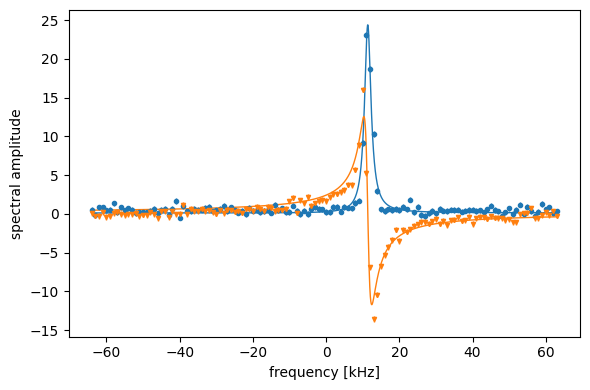

In [8]:
# perform the FFT of the FID
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
freqFit = np.linspace(freq.min(), freq.max(), 10001)
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm=None))
noise = spec[:len(spec)//2].real.std()

# fit the spectrum with the complex Lorentz function
popt = (12e3, 1e3*spec.real.max(), 0.001, 0, 0)
popt, pcov = curve_fit(lorentzFitFct, np.hstack([freq,freq]), np.hstack([spec.real, spec.imag]), 
                       sigma=noise*np.ones(2*len(spec)), absolute_sigma=True, p0=popt)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((np.hstack([spec.real, spec.imag])-lorentzFitFct(np.hstack([freq,freq]), *popt))**2 / (noise*np.ones(2*len(spec)))**2)
chi2_r = chi2 / (2*len(spec) - len(popt))

# print some fit parameters
print('X² / NDF:\t{:.0f} / {} = {:.1f}'.format(chi2, (2*len(spec) - len(popt)), chi2_r))
print('T2*:\t\t({:.0f} +/- {:.0f}) us'.format(1e6*popt[2]/2/np.pi, 1e6*perr[2]/2/np.pi))
print('Sw:\t\t{:.1f} +/- {:.1f}'.format(popt[1]*popt[2], np.sqrt(popt[1]**2*perr[2]**2 + popt[2]**2*perr[1]**2)))

# plot the NMR spectrum
fig, ax = plt.subplots()
ax.errorbar(freq/1e3, spec.real, noise, fmt='C0o', ms=3, lw=1)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).real, 'C0-', lw=1)    
ax.errorbar(freq/1e3, spec.imag, noise, fmt='C1v', ms=3, lw=1)
ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).imag, 'C1-', lw=1)
ax.set(xlabel='frequency [kHz]', ylabel='spectral amplitude')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure11.eps')
plt.show()

## Rabi Measurements

### Resonances for Various Flow Rates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


resonance at 502.2(2) Hz
resonance width 29.5(2) Hz
FWHM 69.4(5) Hz
reduced chi-squared: 1.79

resonance at 502.8(1) Hz
resonance width 33.7(2) Hz
FWHM 79.3(5) Hz
reduced chi-squared: 4.10

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 503.9(2) Hz
resonance width 43.3(3) Hz
FWHM 101.9(6) Hz
reduced chi-squared: 2.06



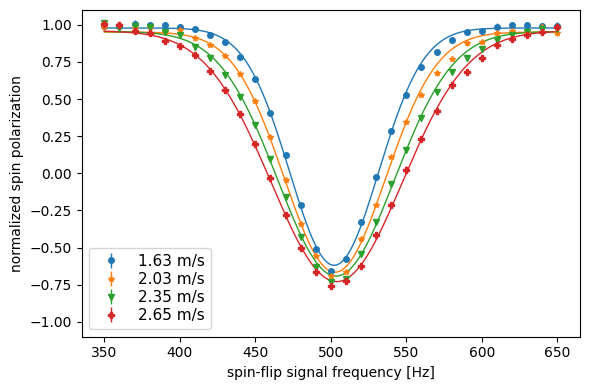

In [9]:
# analyze the data and create the plot
fig, ax = plt.subplots()
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump2500mV_by0050mA.npz', ax=ax, lc='C0', marker='o', ms=4, label='1.63 m/s')
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3000mV_by0050mA.npz', ax=ax, lc='C1', marker='*', ms=4, label='2.03 m/s')
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0050mA.npz', ax=ax, lc='C2', marker='v', ms=4, label='2.35 m/s')
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump4000mV_by0050mA.npz', ax=ax, lc='C3', marker='P', ms=4, label='2.65 m/s')
ax.legend()
ax.set(xlabel='spin-flip signal frequency [Hz]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure12a.eps')
plt.show()

### Resonances at Various Frequencies

resonance at 259.0(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 2.75

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 996.1(1) Hz
resonance width 38.8(2) Hz
FWHM 91.4(5) Hz
reduced chi-squared: 2.33

resonance at 1983.1(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.85



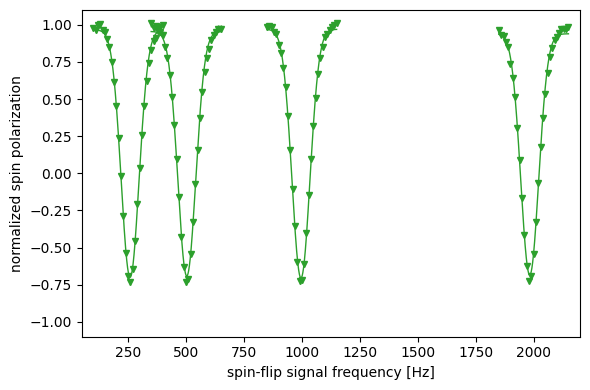

In [10]:
# analyze the data and create the plot
fig, ax = plt.subplots()
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0025mA.npz', ax=ax, lc='C2', marker='v', ms=4, label='25 mA', p0=(250,-100,50,1))
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0050mA.npz', ax=ax, lc='C2', marker='v', ms=4, label='50 mA', p0=(500,-100,50,1))
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0100mA.npz', ax=ax, lc='C2', marker='v', ms=4, label='100 mA', p0=(1000,-100,50,1))
rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0200mA.npz', ax=ax, lc='C2', marker='v', ms=4, label='200 mA', p0=(2000,-100,50,1))
ax.set(xlabel='spin-flip signal frequency [Hz]', ylabel='normalized spin polarization', xlim=(50, 2200), ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure12b.eps')
plt.show()

#### Analyze All Frequencies

In [11]:
# scaling factor between the width of the Gaussian and the FWHM
fwhm_scaling = 2*np.sqrt(2*np.log(2))

# analyze the data for all frequencies without plotting
resWidth = []
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0025mA.npz', p0=(250,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0050mA.npz', p0=(500,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0100mA.npz', p0=(1000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0200mA.npz', p0=(2000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0404mA.npz', p0=(4000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by0505mA.npz', p0=(5000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
popt, perr = rabiFrequencyScan('data/20220303_rabiFrequencyScan_pump3500mV_by1000mA.npz', p0=(10000,-100,50,1))
resWidth.append([fwhm_scaling*popt[2], fwhm_scaling*perr[2]])
resWidth = np.asarray(resWidth)

resonance at 259.0(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 2.75

resonance at 503.5(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(6) Hz
reduced chi-squared: 3.09

resonance at 996.1(1) Hz
resonance width 38.8(2) Hz
FWHM 91.4(5) Hz
reduced chi-squared: 2.33

resonance at 1983.1(1) Hz
resonance width 38.7(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.85

resonance at 3997.8(1) Hz
resonance width 38.6(2) Hz
FWHM 91.0(5) Hz
reduced chi-squared: 3.21

resonance at 5000.4(1) Hz
resonance width 38.5(2) Hz
FWHM 90.7(5) Hz
reduced chi-squared: 4.49

resonance at 9887.4(2) Hz
resonance width 38.4(2) Hz
FWHM 90.4(6) Hz
reduced chi-squared: 2.89



In [12]:
# print the average FWHM
print('Average FWHM: ({:.1f} +/- {:.1f}) Hz'.format(*weighted_mean(resWidth[:,0], resWidth[:,1])))

Average FWHM: (90.9 +/- 0.2) Hz


### Rabi Oscillations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


pi/2 flip at 159.9(3) mVpp
reduced chi-squared: 2.18

pi/2 flip at 188.9(3) mVpp
reduced chi-squared: 1.89

pi/2 flip at 213.0(6) mVpp
reduced chi-squared: 2.04

pi/2 flip at 238.4(13) mVpp
reduced chi-squared: 1.08



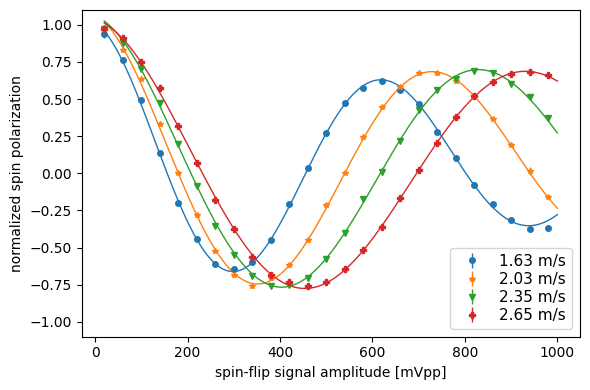

In [13]:
# analyze the data and create the plot
fig, ax = plt.subplots()
rabiAmplitudeScan('data/20220303_rabiAmplitudeScan_pump2500mV_by0050mA.npz', ax=ax, lc='C0', label='1.63 m/s', marker='o', ms=4, p0=(0.0015,1,-90,0,0.001,0))
rabiAmplitudeScan('data/20220303_rabiAmplitudeScan_pump3000mV_by0050mA.npz', ax=ax, lc='C1', label='2.03 m/s', marker='*', ms=4, p0=(0.0015,1,-90,0,0.001,0))
rabiAmplitudeScan('data/20220303_rabiAmplitudeScan_pump3500mV_by0050mA.npz', ax=ax, lc='C2', label='2.35 m/s', marker='v', ms=4, p0=(0.001,1,-90,0,0.001,0))
rabiAmplitudeScan('data/20220303_rabiAmplitudeScan_pump4000mV_by0050mA.npz', ax=ax, lc='C3', label='2.65 m/s', marker='P', ms=4, p0=(0.001,1,-90,0,0.001,0))
ax.legend(loc='lower right')
ax.set(xlabel='spin-flip signal amplitude [mVpp]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure13.eps')
plt.show()

## Ramsey Measurements

### Frequency Scan

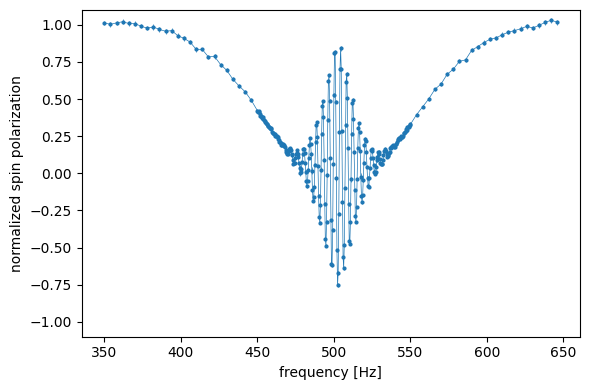

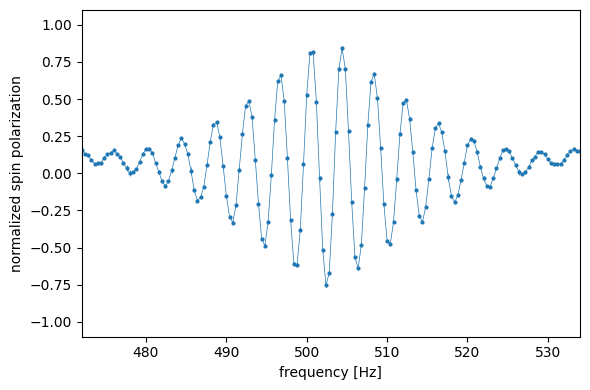

In [14]:
# plot the data
fig, ax = plt.subplots()
ramseyFrequencyScan('data/20220303_ramseyFrequencyScan_pump3500mV_by0050mA.npz', ax=ax, marker='.-', ms=4)
ax.set(xlabel='frequency [Hz]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure14a.eps')
plt.show()

# plot the central frequency range of the data
fig, ax = plt.subplots()
ramseyFrequencyScan('data/20220303_ramseyFrequencyScan_pump3500mV_by0050mA.npz', ax=ax, marker='.-', ms=4)
ax.set(xlabel='frequency [Hz]', ylabel='normalized spin polarization', xlim=(472,534), ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure14b.eps')
plt.show()

### Phase Scan


proton phase: 120.3(3) deg
reduced chi-squared: 0.7

proton phase: 139.8(3) deg
reduced chi-squared: 4.5
magnetic field change: 4.3 nT

proton phase: 180.3(3) deg
reduced chi-squared: 3.2
magnetic field change: 14.7 nT


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


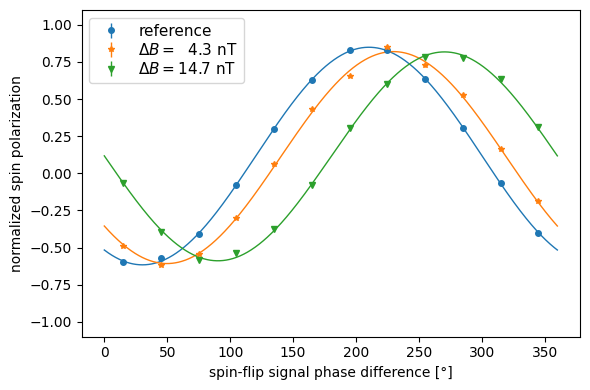

In [15]:
# analyze data and create the plot
fig, ax = plt.subplots()
_,_,B_ref = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-000mA.npz', ax=ax, lc='C0', marker='o', ms=4, label='reference')
_,_,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-020mA.npz', ax=ax, lc='C1', marker='*', ms=4, label='$\Delta B =$  4.3 nT')
print('magnetic field change: {:.1f} nT'.format(1e3*(By_tmp[0]-B_ref[0])))
_,_,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-060mA.npz', ax=ax, lc='C2', marker='v', ms=4, p0=(1,150,0), label='$\Delta B =$14.7 nT')
print('magnetic field change: {:.1f} nT'.format(1e3*(By_tmp[0]-B_ref[0])))
ax.legend()
ax.set(xlabel='spin-flip signal phase difference [°]', ylabel='normalized spin polarization', ylim=(-1.1,1.1))
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure15a.eps')
plt.show()

#### Analyze All Phases

In [16]:
# analyze the data for all phases without plotting
pPhase = []
By = []
popt,perr,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-000mA.npz')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-010mA.npz')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-020mA.npz')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-040mA.npz')
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
popt,perr,By_tmp = ramseyPhaseScan('data/20220330_ramseyPhaseScan_pump3500mV_by0050-060mA.npz', p0=(1,150,0))
pPhase.append([popt[1],perr[1]]); By.append(By_tmp)
pPhase = np.asarray(pPhase).T
By = np.asarray(By).T


proton phase: 120.3(3) deg
reduced chi-squared: 0.7

proton phase: 130.0(3) deg
reduced chi-squared: 5.0

proton phase: 139.8(3) deg
reduced chi-squared: 4.5

proton phase: 160.8(3) deg
reduced chi-squared: 3.2

proton phase: 180.3(3) deg
reduced chi-squared: 3.2


phase coefficient: (4.1 +/- 0.1) deg/nT


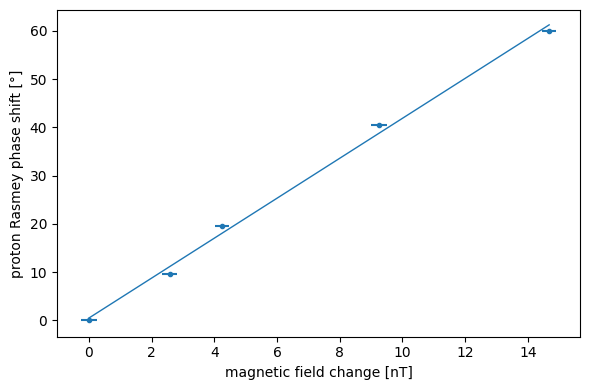

In [17]:
# fit the data and print the coefficient
popt, pcov = np.polyfit(1e3*By[0], pPhase[0], 1, cov=True)
perr = np.sqrt(np.diag(pcov))
deg2nT = np.array([popt[0], perr[0]])
print('phase coefficient: ({:.1f} +/- {:.1f}) deg/nT'.format(*deg2nT))

# create the plot
fig,ax = plt.subplots()
ax.errorbar((By[0]-By[0,0])*1e3, pPhase[0]-pPhase[0,0], pPhase[1], By[1]*1e3, fmt='C0.')
ax.plot((By[0]-By[0,0])*1e3, np.polyval(popt, 1e3*By[0])-pPhase[0,0], 'C0-', lw=1)
ax.set(xlabel='magnetic field change [nT]', ylabel='proton Rasmey phase shift [°]')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure15b.eps')
plt.show()

## Stability

In [18]:
# load preprocessed data for the closed shield
ramseyPhase_closedShield = np.load('data/20220209_ramseyPhase_closedShield.npy')
# average rate from original mdate of the files
Rc = 0.01151135117770809
# number of measurements
Nc = len(ramseyPhase_closedShield[0])

# load preprocessed data for the open shield
ramseyPhase_openShield = np.load('data/20220221_ramseyPhase_openShield.npy')
# average rate from original mdate of the files
Ro = 0.01105442556383233
# number of measurements
No = len(ramseyPhase_openShield[0])

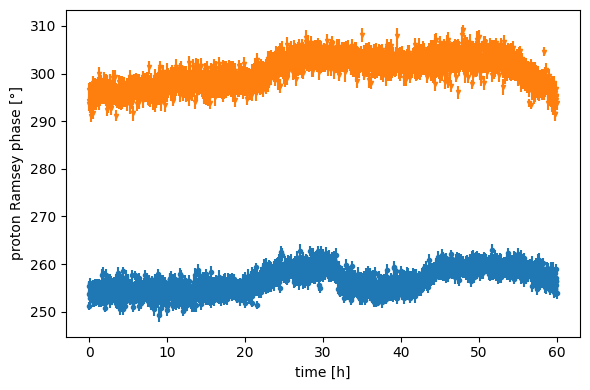

In [19]:
# plot the time course data
fig, ax = plt.subplots()
ax.errorbar(np.arange(Nc)/Rc/3600, ramseyPhase_closedShield[0], ramseyPhase_closedShield[1], fmt='C0o', ms=3, label='full shield')
ax.errorbar(np.arange(No)/Ro/3600, ramseyPhase_openShield[0], ramseyPhase_openShield[1], fmt='C1v', ms=3, label='open shield')
ax.set(xlabel=r'time [h]', ylabel=r'proton Ramsey phase [°]')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure16a.eps')
plt.show()

minimal Allan deviation of closed shield: 
0.34 deg
83 pT

minimal Allan deviation of open shield: 
0.41 deg
98 pT


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


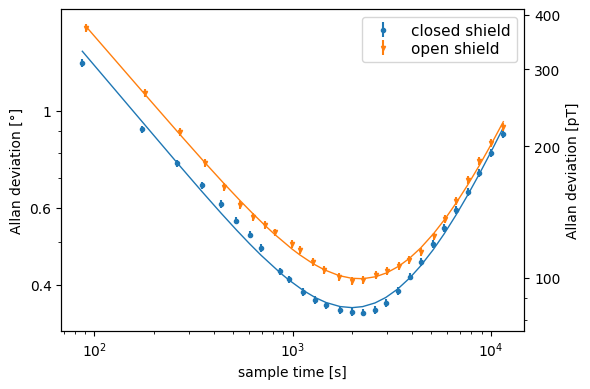

In [20]:
# get numerical values for the minimum and print them
(taus2, ad, ade, ns) = oadev(ramseyPhase_closedShield[0], rate=Rc, data_type='freq', taus='all')
print('minimal Allan deviation of closed shield: ')
print('{:.2f} deg'.format(ad.min()))
print('{:.0f} pT'.format(1e3*ad.min()/deg2nT[0]))
(taus2, ad, ade, ns) = oadev(ramseyPhase_openShield[0], rate=Ro, data_type='freq', taus='all')
print('\nminimal Allan deviation of open shield: ')
print('{:.2f} deg'.format(ad.min()))
print('{:.0f} pT'.format(1e3*ad.min()/deg2nT[0]))

# create the logarithmic x-axis array
maxn = np.floor(np.log2(len(ramseyPhase_openShield[0]))) / 1.5
taus = 1/Ro*np.logspace(0, int(maxn), int(5*maxn+1), base=2.0)

# create the figure
fig, ax = plt.subplots()
ax2 = ax.twinx()

# calculate the overlapping Allan deviation for the closed shield and plot it
(taus2, ad, ade, ns) = oadev(ramseyPhase_closedShield[0], rate=Rc, data_type='freq', taus=taus)
popt, pcov = curve_fit(allanFct, taus2, ad, sigma=ade, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
ax.errorbar(taus2, ad, ade, fmt='C0o', ms=3, label='closed shield')
ax.plot(taus2, allanFct(taus2, *popt), 'C0-', lw=1)
ax2.errorbar(taus2, 1e3*ad/deg2nT[0], 1e3*ade/deg2nT[0], fmt='C0.', ms=0, lw=0)

# calculate the overlapping Allan deviation for the open shield and plot it
(taus2, ad, ade, ns) = oadev(ramseyPhase_openShield[0], rate=Ro, data_type='freq', taus=taus)
popt, pcov = curve_fit(allanFct, taus2, ad, sigma=ade, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
ax.errorbar(taus2, ad, ade, fmt='C1v', ms=3, label='open shield')
ax.plot(taus2, allanFct(taus2, *popt), 'C1-', lw=1)
ax2.errorbar(taus2, 1e3*ad/deg2nT[0], 1e3*ade/deg2nT[0], fmt='C1.', ms=0, lw=0)

# format the plot and show the figure
ax.legend()
ax.set(xlabel=r'sample time [s]', ylabel=r'Allan deviation [°]', xscale='log', yscale='log')
ticks = (0.4,0.6,1)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

ax2.set(ylabel=r'Allan deviation [pT]', yscale='log')
ticks = (100,200,300,400)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks)

fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/figure16b.eps')

plt.show()